In [1]:
# Install required libraries if not already installed
!pip install transformers tensorflow


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from transformers import DistilBertTokenizer
import numpy as np
from transformers import TFDistilBertForSequenceClassification
from tensorflow.keras.optimizers import Adam

In [3]:
#loading the data

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/fancyzhx/yelp_polarity/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/fancyzhx/yelp_polarity/" + splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


EDA

In [4]:
#print the dataframes
print(train_df)
print(test_df)

                                                     text  label
0       Unfortunately, the frustration of being Dr. Go...      0
1       Been going to Dr. Goldberg for over 10 years. ...      1
2       I don't know what Dr. Goldberg was like before...      0
3       I'm writing this review to give you a heads up...      0
4       All the food is great here. But the best thing...      1
...                                                   ...    ...
559995  Ryan was as good as everyone on yelp has claim...      1
559996  Professional \nFriendly\nOn time AND affordabl...      1
559997  Phone calls always go to voicemail and message...      0
559998  Looks like all of the good reviews have gone t...      0
559999  Ryan Rocks! I called him this morning for some...      1

[560000 rows x 2 columns]
                                                    text  label
0      Contrary to other reviews, I have zero complai...      1
1      Last summer I had an appointment to get new ti...      0
2

In [5]:
# Check the shape of the DataFrames
print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

Train Data Shape: (560000, 2)
Test Data Shape: (38000, 2)


In [6]:
# Display the first few rows to verify the content
print(train_df.head())
print(test_df.head())

                                                text  label
0  Unfortunately, the frustration of being Dr. Go...      0
1  Been going to Dr. Goldberg for over 10 years. ...      1
2  I don't know what Dr. Goldberg was like before...      0
3  I'm writing this review to give you a heads up...      0
4  All the food is great here. But the best thing...      1
                                                text  label
0  Contrary to other reviews, I have zero complai...      1
1  Last summer I had an appointment to get new ti...      0
2  Friendly staff, same starbucks fair you get an...      1
3  The food is good. Unfortunately the service is...      0
4  Even when we didn't have a car Filene's Baseme...      1


In [7]:
#print the train data columns
print(train_df.columns)

Index(['text', 'label'], dtype='object')


In [8]:
# Check for null values in the train and test DataFrames
train_nulls = train_df.isnull().sum()
test_nulls = test_df.isnull().sum()

print("Null values in train data:")
print(train_nulls)

print("\nNull values in test data:")
print(test_nulls)

Null values in train data:
text     0
label    0
dtype: int64

Null values in test data:
text     0
label    0
dtype: int64


In [9]:
# Check for duplicates in the train and test DataFrames
train_duplicates = train_df.duplicated().sum()
test_duplicates = test_df.duplicated().sum()

print(f"\nNumber of duplicate rows in train data: {train_duplicates}")
print(f"Number of duplicate rows in test data: {test_duplicates}")


Number of duplicate rows in train data: 0
Number of duplicate rows in test data: 0


In [10]:
# Step 3: Text Preprocessing
import re

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove unwanted characters (special characters, numbers, extra spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [11]:
# Apply text cleaning function to the datasets
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# Step 4: Check and Balance the Dataset (Optional)
# Check label distribution
print("Label distribution in train data after cleaning:")
print(train_df['label'].value_counts())

print("\nLabel distribution in test data after cleaning:")
print(test_df['label'].value_counts())

Label distribution in train data after cleaning:
label
0    280000
1    280000
Name: count, dtype: int64

Label distribution in test data after cleaning:
label
1    19000
0    19000
Name: count, dtype: int64


In [12]:
# Summary statistics for text length
train_df['text_length'] = train_df['text'].apply(len)
print(train_df['text_length'].describe())

count    560000.000000
mean        691.749195
std         637.064701
min           0.000000
25%         266.000000
50%         503.000000
75%         901.000000
max        4914.000000
Name: text_length, dtype: float64


In [13]:
# Distribution of labels in the training and test datasets
print("Label distribution in train data:")
print(train_df['label'].value_counts())

Label distribution in train data:
label
0    280000
1    280000
Name: count, dtype: int64


In [14]:
print("\nLabel distribution in test data:")
print(test_df['label'].value_counts())


Label distribution in test data:
label
1    19000
0    19000
Name: count, dtype: int64


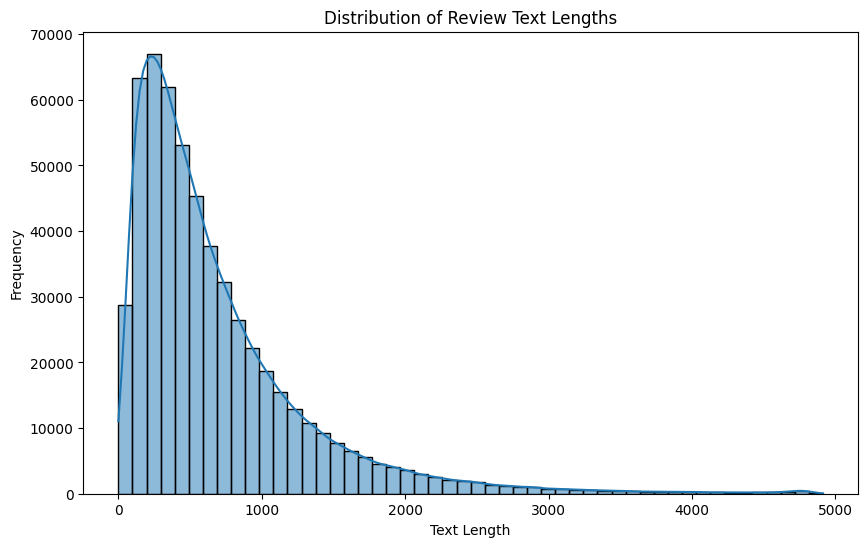

In [15]:
# Histogram of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Correlation between text length and label
correlation = train_df[['text_length', 'label']].corr()
print("Correlation between text length and sentiment label:")
print(correlation)

Correlation between text length and sentiment label:
             text_length     label
text_length     1.000000 -0.140706
label          -0.140706  1.000000


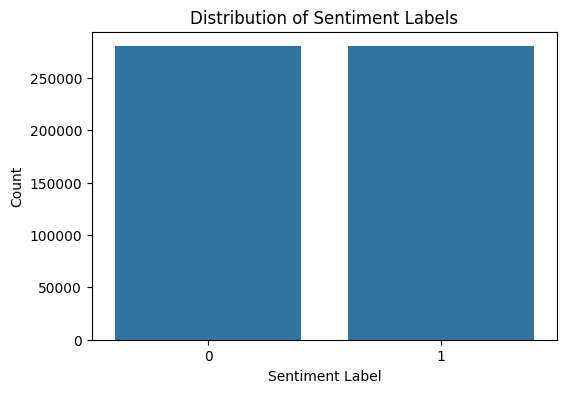

In [17]:
# Bar plot for label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

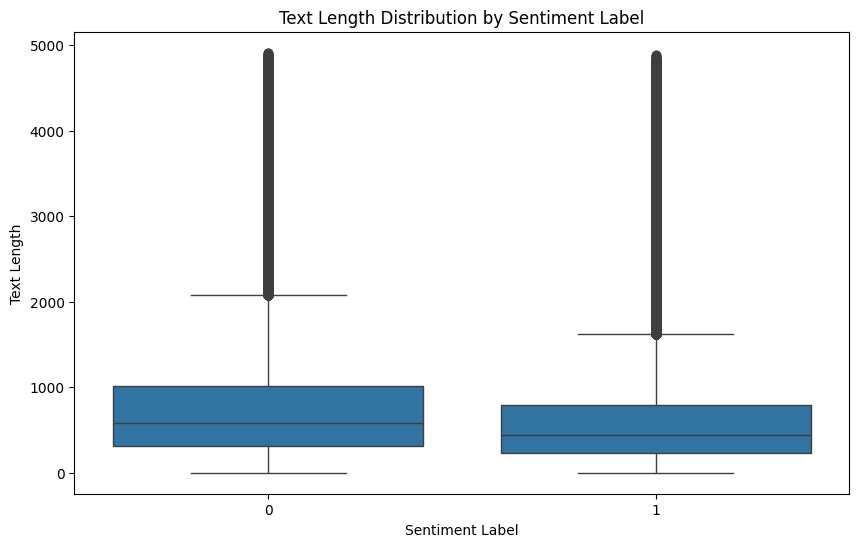

In [18]:
# Box plot for text length by label
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=train_df)
plt.title('Text Length Distribution by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Text Length')
plt.show()

In [19]:
# Limit the train to the first 5,000 rows
train_df = train_df[:5000]

In [20]:
# Check the column names and first few rows
print(train_df.columns)

# Display the first few rows of the DataFrame
print(train_df.head())

Index(['text', 'label', 'text_length'], dtype='object')
                                                text  label  text_length
0  unfortunately the frustration of being dr gold...      0          609
1  been going to dr goldberg for over years i thi...      1          478
2  i dont know what dr goldberg was like before m...      0         1110
3  im writing this review to give you a heads up ...      0         1009
4  all the food is great here but the best thing ...      1          383


In [21]:
# Drop the 'text_length' column and keep only 'text' and 'label'
train_df = train_df[['text', 'label']]

# Verify the new shape and columns
print(f"Train Data Shape after removing 'text_length': {train_df.shape}")
print(train_df.head())


Train Data Shape after removing 'text_length': (5000, 2)
                                                text  label
0  unfortunately the frustration of being dr gold...      0
1  been going to dr goldberg for over years i thi...      1
2  i dont know what dr goldberg was like before m...      0
3  im writing this review to give you a heads up ...      0
4  all the food is great here but the best thing ...      1


In [22]:
# Limit the test DataFrame to the first 1000 rows
test_df = test_df[:1000]

# Verify the new shape of the test DataFrame
print(f"Test Data Shape after limiting: {test_df.shape}")
print(test_df.head())


Test Data Shape after limiting: (1000, 2)
                                                text  label
0  contrary to other reviews i have zero complain...      1
1  last summer i had an appointment to get new ti...      0
2  friendly staff same starbucks fair you get any...      1
3  the food is good unfortunately the service is ...      0
4  even when we didnt have a car filenes basement...      1


In [23]:
# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [24]:
# Tokenize the text data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',  # Pad to max length
        truncation=True,       # Truncate to max length
        max_length=128,        # Max length for BERT
        return_tensors='tf'    # Return as TensorFlow tensors
    )

In [25]:
# Load pre-trained DistilBERT model for sequence classification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels =2)
for layer in model.layers[-5:]:
    layer.trainable = False


# Display the model summary
model.summary()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 66955010 (255.41 MB)
_________________________________________________________________


In [26]:
import tensorflow as tf

def create_tf_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset.map(lambda x, y: (x, tf.reshape(y, (-1,))))

# Tokenize the train and test data
train_encodings = tokenize_function(train_df['text'])
test_encodings = tokenize_function(test_df['text'])

# Convert labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(train_df['label'].values, dtype=tf.int64)
test_labels = tf.convert_to_tensor(test_df['label'].values, dtype=tf.int64)

# Create TensorFlow datasets
train_dataset = create_tf_dataset(train_encodings, train_labels)
test_dataset = create_tf_dataset(test_encodings, test_labels)


In [28]:

# Compile the model
model.compile(
    optimizer="AdamW",
    loss='sparse_categorical_crossentropy',  # Suitable for integer-encoded labels
    metrics=['accuracy']
)


In [29]:
# Define training parameters
batch_size = 64
epochs = 10


# Train the model
history = model.fit(
    train_dataset.shuffle(10000).batch(batch_size),
    validation_data=test_dataset.batch(batch_size),
    epochs=epochs,
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(batch_size))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10
79/79 [==============================] - 50s 348ms/step - loss: 5.7081 - accuracy: 0.5080 - val_loss: 6.3561 - val_accuracy: 0.5170
Epoch 2/10
79/79 [==============================] - 26s 326ms/step - loss: 5.6232 - accuracy: 0.5166 - val_loss: 6.3561 - val_accuracy: 0.5170
Epoch 3/10
79/79 [==============================] - 25s 316ms/step - loss: 5.6962 - accuracy: 0.5120 - val_loss: 6.3561 - val_accuracy: 0.5170
Epoch 4/10
79/79 [==============================] - 26s 331ms/step - loss: 5.6798 - accuracy: 0.5114 - val_loss: 6.3561 - val_accuracy: 0.5170
Epoch 5/10
79/79 [==============================] - 26s 332ms/step - loss: 5.5992 - accuracy: 0.5150 - val_loss: 6.3561 - val_accuracy: 0.5170
Epoch 6/10
79/79 [==============================] - 25s 320ms/step - loss: 5.6352 - accuracy: 0.5096 - val_loss: 6.3561 - val_accuracy: 0.5170
Epoch 7/10
79/79 [==============================] - 25s 316ms/step - loss: 5.7425 - accuracy: 0.5118 - val_loss: 6.3561 - val_accuracy: 0.5170

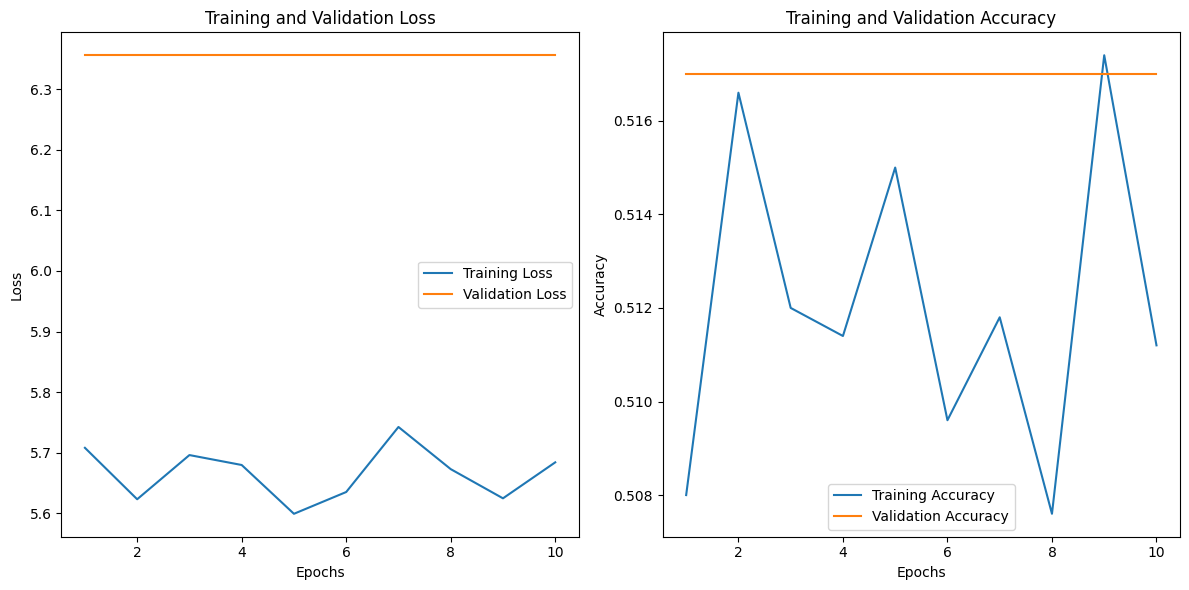

In [30]:
# Extract metrics from the history object
history_dict = history.history
epochs_range = range(1, len(history_dict['loss']) + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dict['loss'], label='Training Loss')
plt.plot(epochs_range, history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dict['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Example text for prediction
texts_to_predict = [
    "The food was great and the service was excellent!",
    "I did not enjoy the meal. The service was slow.",
]

# Tokenize the new texts
pred_encodings = tokenize_function(pd.Series(texts_to_predict))

# Create a TensorFlow dataset for prediction
pred_dataset = tf.data.Dataset.from_tensor_slices(dict(pred_encodings))
pred_dataset = pred_dataset.batch(1)  # Batch size of 1 for predictions


In [32]:
# Make predictions
predictions = model.predict(pred_dataset)

# The model outputs logits; apply softmax to get probabilities
predicted_probs = tf.nn.softmax(predictions.logits, axis=-1)


2/2 [==============================] - 2s 33ms/step


In [33]:

# Convert predictions to class labels
predicted_labels = np.argmax(predicted_probs, axis=-1)

# Print the predictions
for text, label in zip(texts_to_predict, predicted_labels):
    print(f"Text: {text}")
    print(f"Predicted label: {label}")
    print("---")

Text: The food was great and the service was excellent!
Predicted label: 0
---
Text: I did not enjoy the meal. The service was slow.
Predicted label: 0
---
